<a href="https://colab.research.google.com/github/tlchen4/AI-Deep-Learning-Lab-2021/blob/nlp_basic/DLL03_Basics_NLP_Radiology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLL 03 Deep Learning Lab: Basics of NLP in Radiology - RSNA 2024

This session will feature a brief lecture introducing the basics of natural language processing (NLP) and highlight potential uses for it in radiology. This accompanying notebook will provide hands-on opportunity to explore some of the basic tools of NLP available in Python.

**Learning Objectives:**
1.   Understand common terminology and preprocessing techniques in NLP
2.   Identify several classic and modern approaches used to capture semantic meaning in text
3.   Learn how to implement a basic NLP pipeline from preprocessing to performance evaluation

**Recommended Pre-requisites:**
1.   Basic python syntax
2.   Basic usage of python notebooks

**Session Authors**

Timothy L. Chen MD - University of California San Francisco, San Francisco, USA

Gunvant R. Chaudhari MD - University of Washington, Seattle, WA

Cody Savage MD - University of Maryland Medical Center, Baltimore, MD

Jae Ho Sohn MD, MS - University of California San Francisco, San Francisco, USA





# Install Packages

We will use a number of prepackaged python NLP tools for this demonstration. Google colab instances come preloaded with a number of packages but not everything. We will install the missing packages here.

Natural Language Toolkit ([NLTK](https://www.nltk.org/))

[spacy](https://spacy.io/) and [scispacy](https://allenai.github.io/scispacy/)

[gensim](https://radimrehurek.com/gensim/)

[sklearn](https://scikit-learn.org/stable/)






In [ ]:
#@title Installing missing required packages
!pip install xmltodict >/dev/null
!pip install spacy > /dev/null
!pip install scispacy > /dev/null
!pip install negspacy > /dev/null
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_core_sci_md-0.5.3.tar.gz > /dev/null

#! pip freeze

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.7.1 requires spacy<3.8.0,>=3.7.2, but you have spacy 3.6.1 which is incompatible.
scispacy 0.5.5 requires spacy<3.8.0,>=3.7.0, but you have spacy 3.6.1 which is incompatible.


# Acquiring Data

This demo will utilize data from the [Indiana University CXR dataset](https://openi.nlm.nih.gov/faq).

More information regarding the creation of this dataset is detailed in [1] *Demner-Fushman et. al. "Preparing a collection of radiology examinations for distirbution and retrieval". J. Am. Med. Inform. Assoc. 2016. doi: [10.1093/jamia/ocv080](https://academic.oup.com/jamia/article/23/2/304/2572395)*

In [ ]:
# Download the data
# tar options - x -extract, v - show progress of archive file, z - filter archive through gzip
!curl https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz > NLMCXR_reports.tgz
!tar xvf /content/NLMCXR_reports.tgz >/dev/null


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1086k  100 1086k    0     0  1379k      0 --:--:-- --:--:-- --:--:-- 1378k


In [ ]:
# taking a closer look at our file hierarchy
!dir

ecgen-radiology  NLMCXR_reports.tgz  sample_data


With permission from [2] Wiggins et. al., we borrow code to parse the xml. More information about this code can be found here: [Natural Language Processing of Radiology Text Reports: Interactive Text Classification](https://pubs.rsna.org/doi/full/10.1148/ryai.2021210035)

The XML file format stores data under various headers which we store as key-value pairs in a python dictionary object.

Here we first examine the data stucture of one such xml using an explicit file path. We want to extract the relevant text information from each file. We are interested in the text from the "FINDINGS" AND "IMPRESSION" keys. In addition, the reports are labeled as normal under the MeSH key - we will use this for labeling the reports as normal (if normal is present under MeSH) or abnormal.

If we closely examine the data, there are some oddities. Some entries are multiple xrays together. For example, 875.xml contains text for both CXR and a knee X-ray. Some CXR have no text under FINDINGS and IMPRESSION. For some chest x-ray, there is no label given ("No Indexing"). These "No Indexing" labels will be considered as normal for this exercise.

In [ ]:
import xmltodict

# function from Wiggins et. al.
def xml_parse(f):
  with open(f) as xml:
    report_dict = xmltodict.parse(xml.read())
    xml.close()
  return report_dict

Let's take a look at a random xml file and see the contents after parsing

In [ ]:
reportdict_1 = xml_parse("./ecgen-radiology/1404.xml")
reportdict_1

{'eCitation': {'meta': {'@type': 'rr'},
  'uId': {'@id': 'CXR1404'},
  'pmcId': {'@id': '1404'},
  'docSource': 'CXR',
  'IUXRId': {'@id': '1404'},
  'licenseType': 'open-access',
  'licenseURL': 'http://creativecommons.org/licenses/by-nc-nd/4.0/',
  'ccLicense': 'byncnd',
  'articleURL': None,
  'articleDate': '2013-08-01',
  'articleType': 'XR',
  'publisher': 'Indiana University',
  'title': 'Indiana University Chest X-ray Collection',
  'note': 'The data are drawn from multiple hospital systems.',
  'specialty': 'pulmonary diseases',
  'subset': 'CXR',
  'MedlineCitation': {'@Owner': 'Indiana University',
   '@Status': 'supplied by publisher',
   'Article': {'@PubModel': 'Electronic',
    'Journal': {'JournalIssue': {'PubDate': {'Year': '2013',
       'Month': '08',
       'Day': '01'}}},
    'ArticleTitle': 'Indiana University Chest X-ray Collection',
    'Abstract': {'AbstractText': [{'@Label': 'COMPARISON', '#text': 'XXXX'},
      {'@Label': 'INDICATION',
       '#text': 'XXXX y


The entirety of the of the xml data files were uncompressed into the "ecgen-radiology" folder, so we will need to go through each file and extract the relevant information. The [glob](https://docs.python.org/3/library/glob.html) function in the glob module makes this easy by matching all files whose pathname matches a given pattern using [fnmatch](https://docs.python.org/3/library/fnmatch.html#module-fnmatch)

Additionally, we will extract relevant information from each xml file and store it into a pandas dataframe (which is basically a table).

In [ ]:
# functions from Wiggins et. al. , slightly modified to remove dependence on fastai L class

def get_label(report):
    label = report['eCitation']['MeSH']['major']
    return 'normal' if label == 'normal' or label == "No Indexing" else 'abnormal'

# return a dictionary with various report components
def get_text(report):
    text_dict = {}
    text_dict['id'] = report['eCitation']['IUXRId']['@id']
    text = report['eCitation']['MedlineCitation']['Article']['Abstract']['AbstractText']
    findings = text[2]['#text'] if '#text' in text[2] else ''
    text_dict['findings'] = findings
    impression = text[3]['#text'] if '#text' in text[3] else ''
    text_dict['impression'] = impression
    text_dict['full-text'] = ' '.join([findings, impression])
    return text_dict

# return dictionary with one report's components and label
def process_report(report):
    label = get_label(report)
    report_dict = get_text(report)
    report_dict['label'] = label
    return report_dict


In [ ]:
import glob
import pandas as pd

files = glob.glob("./ecgen-radiology/*")
reports = list()
reports_unlabeled = list()

for file in files:
  report_extract = xml_parse(file)
  if report_extract['eCitation']['MeSH']['major'] == "No Indexing":
    reports_unlabeled.append(file)

  reports.append(process_report(report_extract))

reports_df = pd.DataFrame(reports)


Let's examine some of the data in our table

The .head() function will return the first n rows (default 5) of the table. The .sample() method will randomly choose n rows of the table to display (default is 1)

In [ ]:
print("# of reports:",reports_df.shape[0])
pd.options.display.max_colwidth = 0
reports_df.head()

# of reports: 3955


,id,findings,impression,full-text,label
0,2780,The heart and lungs have XXXX XXXX in the interval. Both lungs are clear and expanded. Heart and mediastinum normal.,No active disease.,The heart and lungs have XXXX XXXX in the interval. Both lungs are clear and expanded. Heart and mediastinum normal. No active disease.,normal
1,2080,,Well-expanded and clear lungs. Conspicuous for size 3-4 mm nodular opacity projecting in right lung is probably a small calcified granuloma. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified.,Well-expanded and clear lungs. Conspicuous for size 3-4 mm nodular opacity projecting in right lung is probably a small calcified granuloma. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified.,abnormal
2,2474,"Patchy interstitial infiltrates have developed in both lower lobes. Both costophrenic XXXX are blunted. Aorta is somewhat tortuous, with the heart size is normal. Pulmonary XXXX are normal.",Bibasilar patchy airspace disease with bilateral small pleural fluid collections.,"Patchy interstitial infiltrates have developed in both lower lobes. Both costophrenic XXXX are blunted. Aorta is somewhat tortuous, with the heart size is normal. Pulmonary XXXX are normal. Bibasilar patchy airspace disease with bilateral small pleural fluid collections.",abnormal
3,1626,"The heart is normal in size. The mediastinal contours are within normal limits. There are numerous bilateral pulmonary nodules of varying sizes. The largest is noted in the left lower lobe, posteriorly measuring approximately 7.0 cm. No acute infiltrate or pleural effusion are appreciated.",Numerous bilateral pulmonary nodules with dominant nodule/mass in the left lower lung. Diagnostic considerations would include primary lung carcinoma with metastatic nodules versus secondary metastatic disease from known brain tumor. Suggest clinical correlation and further imaging XXXX examination.,"The heart is normal in size. The mediastinal contours are within normal limits. There are numerous bilateral pulmonary nodules of varying sizes. The largest is noted in the left lower lobe, posteriorly measuring approximately 7.0 cm. No acute infiltrate or pleural effusion are appreciated. Numerous bilateral pulmonary nodules with dominant nodule/mass in the left lower lung. Diagnostic considerations would include primary lung carcinoma with metastatic nodules versus secondary metastatic disease from known brain tumor. Suggest clinical correlation and further imaging XXXX examination.",abnormal
4,2136,Mediastinal contours are normal. Lungs are clear. There is no pneumothorax or large pleural effusion.,No acute cardiopulmonary abnormality.,Mediastinal contours are normal. Lungs are clear. There is no pneumothorax or large pleural effusion. No acute cardiopulmonary abnormality.,normal


In [ ]:
reports_df.sample(5)

,id,findings,impression,full-text,label
591,152,"Stable cardiomediastinal silhouette with mild cardiomegaly and aortic ectasia and tortuosity. No alveolar consolidation, no findings of pleural effusion. Chronic appearing bilateral rib contour deformities compatible with old fractures. No pneumothorax.",No acute findings.,"Stable cardiomediastinal silhouette with mild cardiomegaly and aortic ectasia and tortuosity. No alveolar consolidation, no findings of pleural effusion. Chronic appearing bilateral rib contour deformities compatible with old fractures. No pneumothorax. No acute findings.",abnormal
1214,178,"Cardiomediastinal silhouette stable with atherosclerosis of the thoracic aorta. Diffusely coarsened interstitial markings are noted consistent with chronic lung disease, with worsened patchy opacities and a left apex and right base. No pneumothorax or pleural effusion. No acute bony abnormality.",Changes of chronic interstitial lung disease with ill-defined patchy left apical and right basilar airspace disease. PA and lateral chest radiograph may be of benefit XXXX clinically feasible.,"Cardiomediastinal silhouette stable with atherosclerosis of the thoracic aorta. Diffusely coarsened interstitial markings are noted consistent with chronic lung disease, with worsened patchy opacities and a left apex and right base. No pneumothorax or pleural effusion. No acute bony abnormality. Changes of chronic interstitial lung disease with ill-defined patchy left apical and right basilar airspace disease. PA and lateral chest radiograph may be of benefit XXXX clinically feasible.",abnormal
985,1625,The heart is normal in size. The mediastinum is stable. Atherosclerotic calcifications of the aortic XXXX are present. The lungs are clear.,No acute disease.,The heart is normal in size. The mediastinum is stable. Atherosclerotic calcifications of the aortic XXXX are present. The lungs are clear. No acute disease.,abnormal
2442,3857,"The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. Osseous structures are within normal limits for patient age..",1. No acute radiographic cardiopulmonary process.,"The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. Osseous structures are within normal limits for patient age.. 1. No acute radiographic cardiopulmonary process.",normal
2923,3005,"The heart is normal in size. The mediastinum is stable. Aorta is tortuous. Calcified lymph XXXX are again identified. There is mild prominence of the right paratracheal soft tissues, stable in appearance from prior studies. There is no acute infiltrate or pleural effusion. Osteopenia and degenerative changes are identified. XXXX deformity of T9 appears worse than prior study.","1. Emphysema without acute infiltrate. 2. Progressive XXXX deformity of midthoracic vertebral body, XXXX T9.","The heart is normal in size. The mediastinum is stable. Aorta is tortuous. Calcified lymph XXXX are again identified. There is mild prominence of the right paratracheal soft tissues, stable in appearance from prior studies. There is no acute infiltrate or pleural effusion. Osteopenia and degenerative changes are identified. XXXX deformity of T9 appears worse than prior study. 1. Emphysema without acute infiltrate. 2. Progressive XXXX deformity of midthoracic vertebral body, XXXX T9.",abnormal


# Some characteristics of the data

We previously already noticed that not all reports had labels associated with them and kept track of a list of such reports in reports_unlabeled. Through further examination of the data we see that some reports (e.g. id 68) only have an impression section but no findings section. THere are also numerous XXXX in reports which likely represent placeholder text after PHI removal (names, dates, etc). Even for normal labeled reports, there is quite a large amount of variation in the text of the reports.

## Distribution of labels

For any data, it is important to examine the distribution of classes (labels) of the data. Imbalanced datasets can have large impacts in terms of how a model behaves after training.

Abnormal: 2469
Normal: 1486



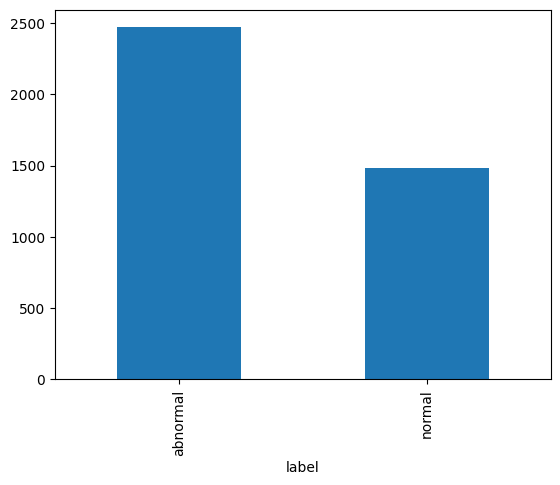

In [ ]:
# code from Wiggins et. al.

label_counts = reports_df.label.value_counts()
print('Abnormal:', label_counts['abnormal'])
print('Normal:', label_counts['normal'])
print()
label_counts.plot.bar();

# Training and test set split

We will carve the data into two separate data sets - a training set to train the model and a test set to evaluate the model performance. It is necessary to use a separate dataset on which the model is not trained to evaluate the model because models can overfit onto training data and perform very well on that particular dataset but fail to generalize to examples it has not seen before.

Similarly, a third validation set is sometimes employed as part of the model development process for hyperparameter tuning which is  part of the training process.

For simplicity, we will use a single stratified train-test split, but a cross-validation approach with multiple train-test splits can offer better insight into how a model performs.

The stratification refers to how the sampling is done when the data is split into separate data sets. This is important when there is class imbalance in the dataset because you could conceivably end up with one dataset only having members of one class.

The stratify option in the train_test_split function takes the labels of the dataset as input. When this option is enabled, the sampler will attempt to preserve class proportions of the input dataset (aka the input dataset labels) in the split datasets via stratified sampling. Note this does not solve the class imbalance problem on its own.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# fix seed for reproducibility
np.random.seed(2023)

train_df, test_df = train_test_split(reports_df, test_size=0.15, stratify=reports_df.label.values)

If we examine the dataset labels of the test set, we can see that we have similar proportions of abnormal and normal labels compared to the original full dataset (approx 62% abnormal)

Test set size: 594
Abnormal: 371 (62.5 %)
Normal:   223 (37.5 %)



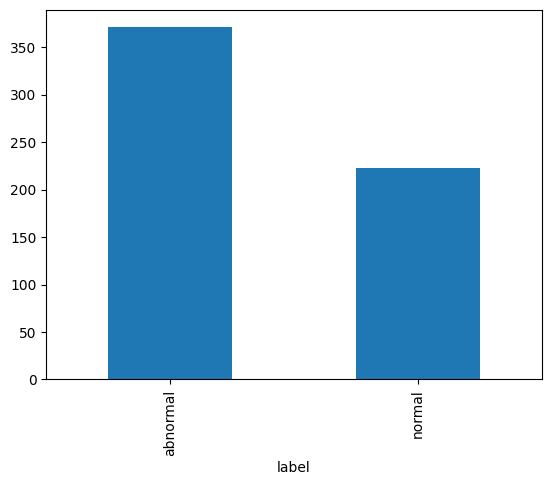

In [ ]:
# code from Wiggins et. al.

print('Test set size:', test_df.shape[0])
test_counts = test_df.label.value_counts()
test_counts_normalized = test_df.label.value_counts(normalize=True)
print('Abnormal: %d (%0.1f %%)' % (test_counts['abnormal'], 100*test_counts_normalized['abnormal']))
print('Normal:   %d (%0.1f %%)'% (test_counts['normal'], 100*test_counts_normalized['normal']))
print()
test_counts.plot.bar();

# Preprocessing

Most models will not understand a stream of free text as is. Before we can use our data as input into a model, we need to convert it into a form that can be understood by an algorithm. Often this is done by creating a "vocabulary" of words such that every unique word has a unique index and thus we can input a word's index as input into a model (or use the index to look up some numerical representation of the word).

The following sections will examine pieces of a preprocessing pipeline in isolation using independent sections of code but then put these pieces together as one function at the end.

## Regular expressions (regex)
The data used in this tutorial was already nicely packaged into distinct Findings and Impression sections. Most of the time when working with radiology reports you'll have to divide the report into these separate entities yourself. One way to do this is with regular expressions which are rule based expressions that can match patterns of text. Regular expressions can be a powerful way to automatically segment reports or identify sections of text if pre-existing knowledge about their format is known.

[Cheat sheet](https://web.mit.edu/hackl/www/lab/turkshop/slides/regex-cheatsheet.pdf) for regex syntax

We will not extensively cover regular expression nuances in this tutorial but just show a simple example of how they are used with respect to the Python re package. Regular expressions are a general framework thus you may also see packages outside of the re package which interface with regular expressions.

More about regular expressions can be found [here](https://www.regular-expressions.info/refflavors.html).


In [ ]:
#@title
import re

regex_test_string = """
123-456-7890
(123)456-7890
(123)-456-7890
123 456 7890
123.456.7890
+1-123-456-7890
+1 (321) 456-7890
+91 123-456-7890
"""

regex_pattern = "\+?(\d{1,3})?[-. (]?[-. (]?(\d{3})[-. )]?[-. )]?\d{3}[-. ]?\d{4}"#@param {type:"string"}
m = re.finditer(regex_pattern,regex_test_string)

for match in m:
  print(match.group())
  print(f"Area code is {match.group(2)}\n")

123-456-7890
Area code is 123

(123)456-7890
Area code is 123

(123)-456-7890
Area code is 123

123 456 7890
Area code is 123

123.456.7890
Area code is 123

+1-123-456-7890
Area code is 123

+1 (321) 456-7890
Area code is 321

+91 123-456-7890
Area code is 123



Note by default regex does greedy matching
Greedy matching - match as much as text as possible to fulfill the pattern even if a smaller subsection of the text would have already fulfilled the pattern.

In the following example we look for a string that begins with "h", has at least one character of anything except line breaks, and then an "l".

If our test string is "hello" , then the substring "hel" matches our objective but so does "hell" if we go one character further. The default behavior is to return the longer version (hence greedy). If we wanted the non-greedy version, adding a "?" after a quantifier makes it non-greedy.

In [ ]:
#@title Greedy
regex_pattern = "h.+l"
m = re.finditer(regex_pattern,"hello")
for match in m:
  print(match.group())

hell


In [ ]:
#@title Non-greedy
regex_pattern = "h.+?l"
m = re.finditer(regex_pattern,"hello")
for match in m:
  print(match.group())

hel


## Regex practice problems

Answers at the bottom of this notebook

In [ ]:
#@title Question 1: Find and remove all punctuation within the text block

# Fill out the pattern here to identify punctuations
regex_pattern = '' #@param {type:"string"}

text_block = """
There is no significant end-vessel ischemic small vessel disease.
There is no acute infarct seen.
No intracranial hemorrhage is recognized.
"""
out_text = re.sub(regex_pattern, ' ', text_block)

print(out_text)

 
 T h e r e   i s   n o   s i g n i f i c a n t   e n d - v e s s e l   i s c h e m i c   s m a l l   v e s s e l   d i s e a s e . 
 T h e r e   i s   n o   a c u t e   i n f a r c t   s e e n . 
 N o   i n t r a c r a n i a l   h e m o r r h a g e   i s   r e c o g n i z e d . 
 


In [ ]:
#@title Question 2: Extract full impression from the text block

# Fill out the pattern here to identify impression text
regex_pattern = '' #@param {type:"string"}

text_block = """
FINDINGS:
FLUID / INTRA-ARTICULAR BODIES: There is a small knee effusion and a small popliteal cyst present. There is circumferential soft tissue edema and swelling at the level the knee most prominent posteriorly.
MENISCI:
Medial: The medial meniscus is normal.
Lateral: The lateral meniscus is normal.

IMPRESSION
1. There are extensive bone contusions of the distal femur and proximal tibia. There is a nondisplaced Salter II fracture through the growth plate of the distal femur. There is a subperiosteal hematoma with displacement of the periosteum along the posterolateral aspect of the distal femoral metaphysis.
2. Extensive bone contusion of the proximal tibia with a small incomplete nondisplaced transverse fracture line noted along the posterior margin of the proximal tibial metaphysis.
"""

m = re.search(regex_pattern,text_block)
for group in m.groups():
  print(group)
  print()


## Word tokenization

The first step in processing text is often tokenization. This is a process in which text is split into discrete sections which are known as tokens. A natural place to create these sections (for English) is dividing at spaces so that each word represents a token. However, tokens could also be defined at a phrase level (multiple words), sentence level, or character level. For simplicity here, we will tokenize at the single word level.

In [ ]:
import nltk
nltk.download('punkt_tab')
text = "Heart size upper limits of normal. Mediastinal contours are maintained. The patient is mildly rotated. There is a small to moderate sized right apical pneumothorax which measures approximately 2.0 cm. No focal airspace consolidation is seen. Left chest is clear. No definite displaced bony injury is seen. Results called XXXX. XXXX XXXX p.m. XXXX, XXXX. Small to moderate right apical pneumothorax."
text_tokens = nltk.tokenize.word_tokenize(text)
print(text_tokens)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


['Heart', 'size', 'upper', 'limits', 'of', 'normal', '.', 'Mediastinal', 'contours', 'are', 'maintained', '.', 'The', 'patient', 'is', 'mildly', 'rotated', '.', 'There', 'is', 'a', 'small', 'to', 'moderate', 'sized', 'right', 'apical', 'pneumothorax', 'which', 'measures', 'approximately', '2.0', 'cm', '.', 'No', 'focal', 'airspace', 'consolidation', 'is', 'seen', '.', 'Left', 'chest', 'is', 'clear', '.', 'No', 'definite', 'displaced', 'bony', 'injury', 'is', 'seen', '.', 'Results', 'called', 'XXXX', '.', 'XXXX', 'XXXX', 'p.m.', 'XXXX', ',', 'XXXX', '.', 'Small', 'to', 'moderate', 'right', 'apical', 'pneumothorax', '.']


Pretrained tokenizers on large corpus of text are readily available. The details of how they are trained are beyond the scope of this course. Many implementations of these models are available from the Hugging face library ([See documentation](https://huggingface.co/docs/transformers/v4.46.3/en/model_doc/auto#transformers.AutoTokenizer)).

Here we briefly examine how the BERT tokenizer processes the same sentence above. For the most part it is the same, but note the sub-word level tokenization (e.g. how the word "Mediastinal" is split into 3 tokens: "Media", "##st" and "##inal"). This technique may be helpful for navigating vocabularies with complex word structures while keeping the vocabulary a reasonable size.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

print(tokenizer.tokenize(text))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

['Heart', 'size', 'upper', 'limits', 'of', 'normal', '.', 'Media', '##st', '##inal', 'con', '##tour', '##s', 'are', 'maintained', '.', 'The', 'patient', 'is', 'mildly', 'rotated', '.', 'There', 'is', 'a', 'small', 'to', 'moderate', 'sized', 'right', 'a', '##pical', 'p', '##ne', '##um', '##oth', '##orax', 'which', 'measures', 'approximately', '2', '.', '0', 'cm', '.', 'No', 'focal', 'airs', '##pace', 'consolidation', 'is', 'seen', '.', 'Left', 'chest', 'is', 'clear', '.', 'No', 'definite', 'displaced', 'bony', 'injury', 'is', 'seen', '.', 'Results', 'called', 'X', '##X', '##X', '##X', '.', 'X', '##X', '##X', '##X', 'X', '##X', '##X', '##X', 'p', '.', 'm', '.', 'X', '##X', '##X', '##X', ',', 'X', '##X', '##X', '##X', '.', 'Small', 'to', 'moderate', 'right', 'a', '##pical', 'p', '##ne', '##um', '##oth', '##orax', '.']


## Stopword removal

Stop words are high-frequency words in language that tend to appear in any context due to their grammatical role (e.g. "a", "the", "of"). They generally do not contain much information, so it is customary to remove these words as part of the prprocessing step. In general this works well, but phrases that rely on stopwords can lose meaning (e.g. "to be or not to be").

In this case, XXXX should be removed as well.

Removal of stopwords is as simple as defining a set of words that you want to remove and then removing these words by scanning through input text and filtering out words that are within the set.


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


The imported stopwords exist originally as a list structure, but we should convert to a set for better performance. We can also add custom words to expand this set. Notice our set of stopwords is also all lower case. We will lowercase our tokens prior to matching to the stopword set.

In addition to stopwords, numbers are often removed as well (e.g. list numberings) but in the context of radiology these numbers can be very important (e.g. size of a lung nodule).

In [ ]:
import string
stop = set(stopwords.words('english')+list(string.punctuation))
stop.add("xxxx")

filtered_tokens = [i.lower() for i in text_tokens if i.lower() not in stop ]
print(filtered_tokens)

['heart', 'size', 'upper', 'limits', 'normal', 'mediastinal', 'contours', 'maintained', 'patient', 'mildly', 'rotated', 'small', 'moderate', 'sized', 'right', 'apical', 'pneumothorax', 'measures', 'approximately', '2.0', 'cm', 'focal', 'airspace', 'consolidation', 'seen', 'left', 'chest', 'clear', 'definite', 'displaced', 'bony', 'injury', 'seen', 'results', 'called', 'p.m.', 'small', 'moderate', 'right', 'apical', 'pneumothorax']


## Word normalization - stemming and lemmatization

Word (or text) normalization is reducing text to a standardized form before processing. One way to do this is word stemming and/or lemmatization. In word stemming, the suffix of a word is removed, often leaving behind a stem that is not a full word. In lemmatization, words are transformed into a base word. For example, it is common to remove verb conjugations to reduce different forms of a verb to a single word/token - transforming flying, flown, flew -> fly.

We will introduce the concept here, but it will not be included within the preprocessing pipeline. Medical stemming is a difficult topic due to many words sharing roots while still having different meanings (e.g. pneumonia, pneumonitis, pneumonic, pneumothorax). Most available stemming packages are not designed for medical stemming and could introduce problems by truncating useful parts of words ("over stemming").

In addition to stemming/lemmatizing words which are based on word roots, one can normalize words by mapping words to a controlled vocabulary. This is especially useful in medicine where a number of terms could refer to the same entity (e.g. hepatorenal recess vs subhepatic recess vs pouch of Morison vs Morison's pouch). Examples of efforts to create standardized medical vocabulary include [UMLS](https://www.nlm.nih.gov/research/umls/index.html), [SNOMED-CT](https://www.nlm.nih.gov/healthit/snomedct/index.html), and [RadLex](http://radlex.org/)

In [ ]:
import nltk
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package wordnet to /root/nltk_data...


The [Porter Stemmer](http://snowball.tartarus.org/algorithms/porter/stemmer.html) is a commonly used stemmer which uses an extensive rule based approach to stem words. The stems generated by stemming may not be "real" words which is ok as the point is to normalize similar words into the same token.

In [ ]:
stemmer = PorterStemmer()
stemmer.stem("flying")

'fli'

In [ ]:
print(stemmer.stem("pneumonic"))
print(stemmer.stem("pneumonitis"))

pneumon
pneumon


For lemmatization demonstration, we will use the NLTK default lemmatizer which is based on [WordNet](https://wordnet.princeton.edu/). In addition to the target text, the [lemmatizer](https://www.nltk.org/_modules/nltk/stem/wordnet.html) will generally require a part of speech parameter to be fully functional (default is noun)

In [ ]:
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize("flown",pos="v"))

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


fly


## Negation

Dealing with negation is important especially when using a bag of word model because it ignores word ordering. The presence of a word in a document does not mean we necessarily want it to always be used as the same feature especially if the word is qualified by "no" (e.g. no nodule). One way to deal with this is to detect such negated words/phrases and create "new" vocab words out of negated entities by appending some text to it (for example append "NEGEX_" to negated entities so that these entities are counted as separated words compared to their non-negated counterpart)

spacy comes with pre-trained [models](https://github.com/explosion/spacy-models) for purposes of preprocessing (e.g. named entity recognition) and also [negation](https://github.com/jenojp/negspacy). Here we will use a default implementation of negspacy for negation detection.

In [ ]:
import scispacy
import spacy
from negspacy.negation import Negex
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from negspacy.termsets import termset
ts = termset("en_clinical_sensitive")

ts.add_patterns(
    {
        "preceding_negations":["no acute", "negative for", "no evidence of"],
        "following_negations":["are within normal limits", "is unremarkable"],
        "termination":["there are"],
        "pseudo_negations":["may represent"]
    }

)

nlp = spacy.load("en_core_sci_md")
nlp.add_pipe("negex", config={"chunk_prefix":["no"],"neg_termset":ts.get_patterns()},last=True)


/usr/local/lib/python3.10/dist-packages/spacy/language.py:2141: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


What kind of phrases is negex recognizing as negation? We can print the default patterns from negspaCy to see. The "en_clinical" dataset is used by default. Default termsets also include "en" and "en_clinical_sensitive". The official documentation covers how to change term sets and also how to add/remove custom phrases to the sets.

From the documentation, negspaCy uses four patterns:

**pseudo_negations** - phrases that are false triggers, ambiguous negations, or double negatives

**preceding_negations** - negation phrases that precede an entity

**following_negations** - negation phrases that follow an entity

**termination** - phrases that cut a sentence in parts, for purposes of negation detection (.e.g., "but")

In [ ]:
from negspacy.termsets import termset

ts = termset("en_clinical_sensitive")
ts_dict = ts.get_patterns()

for key,value in ts_dict.items():
  print(key,value)
  print("\n")

pseudo_negations ['no significant change', 'not cause', 'no change', 'without difficulty', 'not ruled out', 'not certain if', 'not extend', 'no further', 'no definite change', 'may represent', 'not only', 'without further', 'might not', 'no suspicious change', 'no interval change', 'not drain', 'no increase', 'not necessarily', 'not able to be', 'not rule out', 'gram negative', 'not certain whether', 'no significant interval change', 'not been ruled out', 'without any further']


preceding_negations ["wasn't", 'rule patient out', "weren't", 'versus', 'ruled the patient out', 'evaluate for', 'never', 'symptoms atypical', 'not', 'rule the patient out', 'rule him out', 'no', 'tested for', 'cannot', 'werent', 'didnt', 'teach the patient', "isn't", 'monitor for', 'rule her out', 'cant', 'no cause of', 'doubt', "aren't", 'teaching the patient', 'no evidence of', 'if you get', 'instead of', 'leads to', 'no signs of', 'never had', 'fails to reveal', 'educate the patient', 'educating the patien

## Putting it all together

In [ ]:
import nltk
nltk.download("wordnet")
from nltk.corpus import stopwords

def preprocess(nlp_model,input_text):
  input_text = input_text.strip()
  doc = nlp_model(input_text)
  negation_list = [0]*len(doc)
  tokens = list()
  stop = set(stopwords.words('english')+list(string.punctuation))
  stop.add("XXXX")
  stop.add("the")


  for ent in doc.ents:
    if ent._.negex:
      index = ent.start
      while index < ent.end:
        negation_list[index] = 1
        index += 1

  for i,token in enumerate(doc):
    if str(token) not in stop:
      if negation_list[i] == 1:
        tokens.append(("NEGEX_"+str(token).lower()))
      else:
        tokens.append(str(token).lower())

  return tokens


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Creating a vocabulary
After preprocessing the text, it is time to scan through the entire training corpus (aka all of the text available) and create a vocabulary which is essentially an index of all unique tokens encountered.

We will use the gensim [Dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html) class for this as it has some useful methods.

We can also set a threshold to filter out tokens using the gensim dict method filter_extremes() that occur below a specified frequency. This could be useful for removing misspelled words.

In [ ]:
from gensim.corpora import Dictionary

train_text = train_df["full-text"].to_list()

def token_generator(text_list):
  for text in text_list:
    #nlp is global variable from above
    yield preprocess(nlp,text)

train_tokens = token_generator(train_text)
train_vocab_dict = Dictionary(train_tokens)

# gensim Dictionary does not create an id2token dictionary  until dictionary is called
train_vocab_dict[0]

'1'

In [ ]:
len(train_vocab_dict.token2id)

2437

We will also need to process the test set for later use. Note we don't create a dictionary from the test tokens as it is may contain "out of vocabulary words" that would not have been seen in training. We need to simulate how our model pipeline behaves when it encounters unseen text/words.

In [ ]:
test_text = test_df["full-text"].to_list()
test_tokens = token_generator(test_text)

# Classification model - introducing Naive Bayes

## Theory

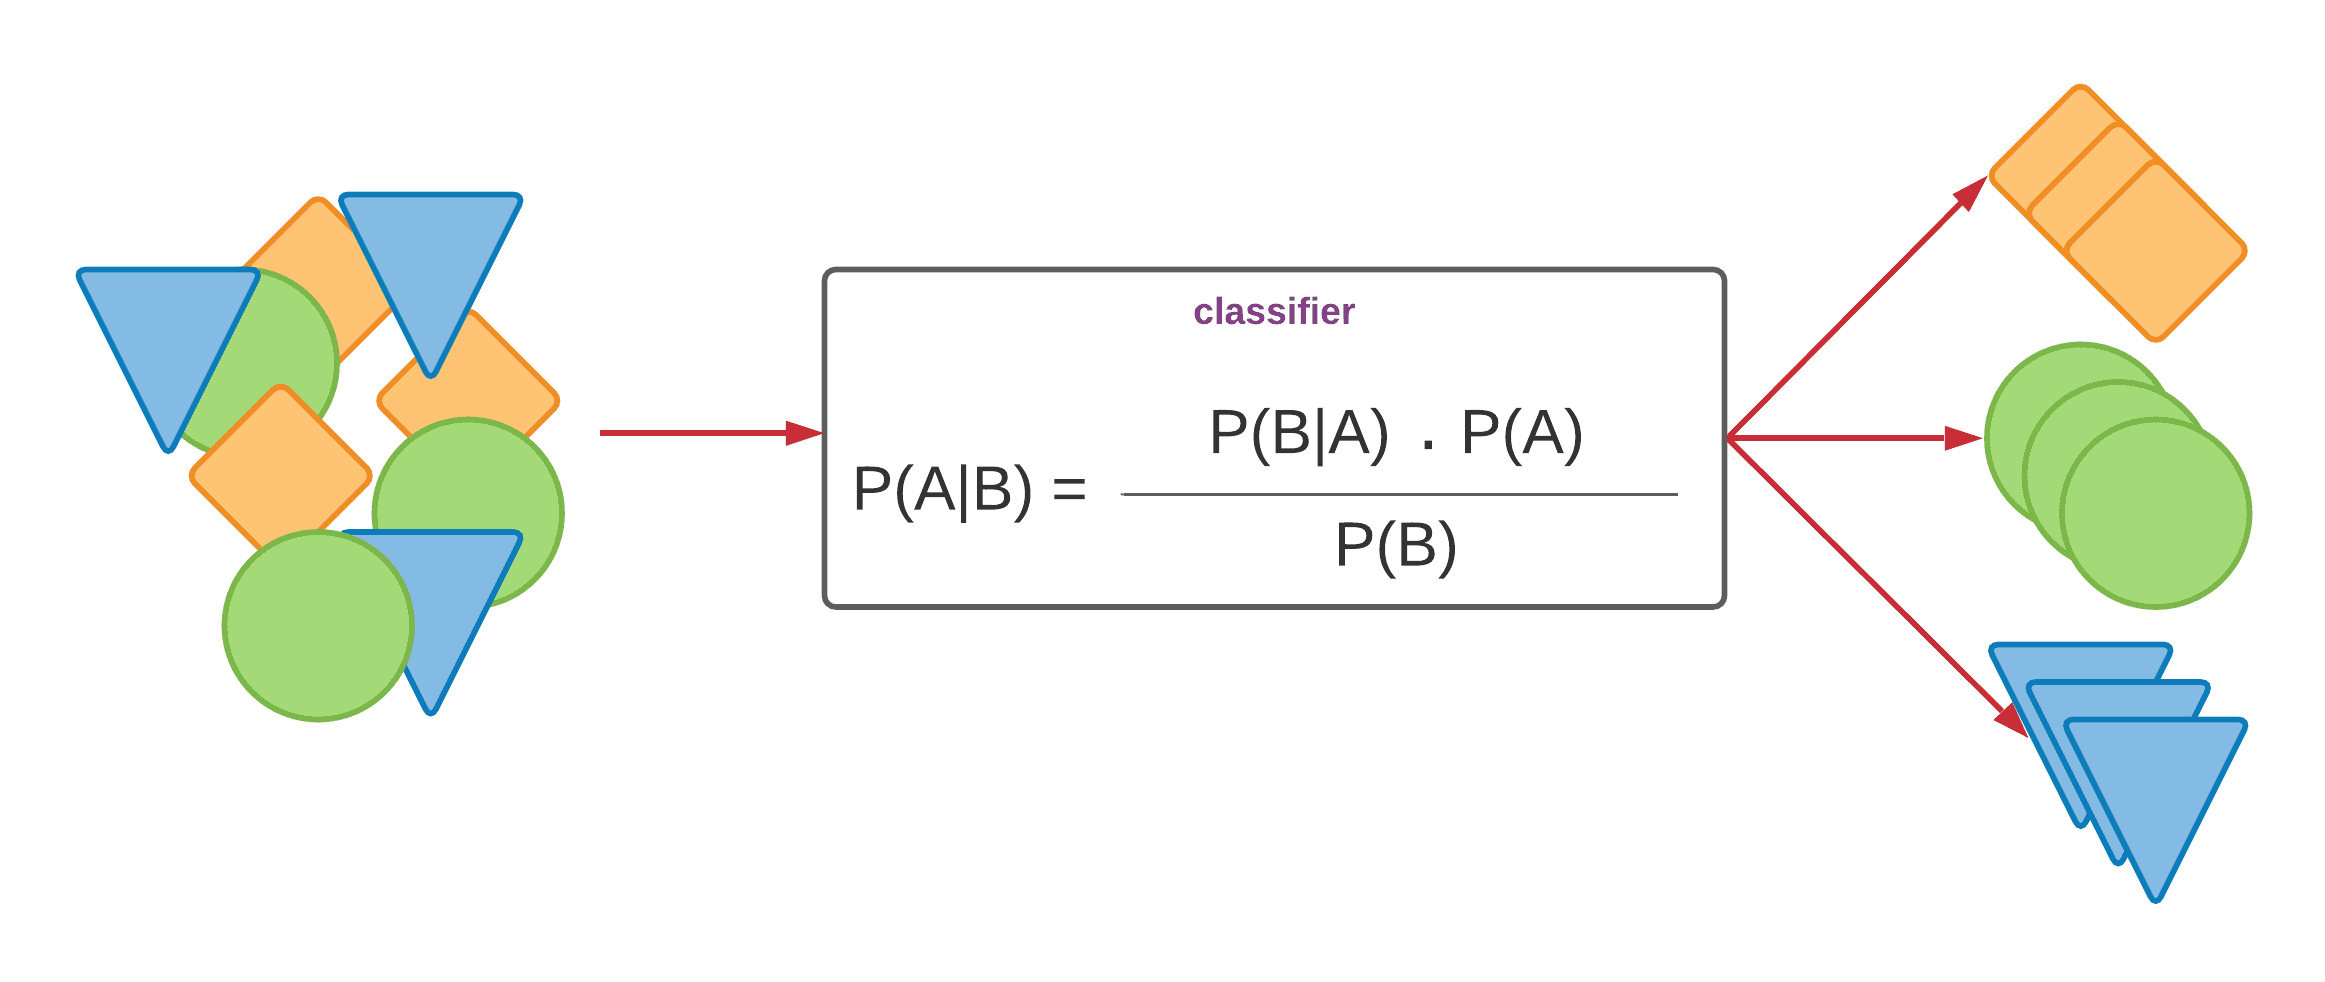

where "A" is a category (e.g. "abnormal") and "B" is a document (e.g. one report's text).
[Figure reference](https://hands-on.cloud/implementing-naive-bayes-classification-using-python/)

Naive Bayes (NB) derives its name from Bayes' theorem.

Our objective is to classifiy a document d with the best possible class prediction, $\hat{c}$, where $c$ is the true class of document $d$. In our case the possible classes are abnormal or normal.

$ \hat{c} = \underset{c \in C}{argmax} \: P(c|d) = \underset{c \in C}{argmax} \frac{P(d|c)P(c)}{P(d)} $

$P(d)$ is a constant so we can just find the class c that maximizes the numerator of the expression

$ \hat{c} = \underset{c \in C}{argmax} \: P(d|c)P(c) $

$P(c)$ is readily determined - it is the frequency/probablity of class c in the training set compared to other classes.

For $P(d|c)$, we let the words (tokens) of document d be the "features" that define it. We assume the order of these features does not matter (bag of words) and that the probability of a given feature(word) occurring in document d is independent of other words already inside of document d (conditional independence between every pair of tokens).

Based on this $P(d|c) = P(x_{1}, x_{2},...,x_{n}| c)$ where $x_i$ are the tokens x in d. If we assume independence among these words then this probability further breaks down into:

$\prod_{i = 1}^{n}{P(x_{i}|c)}$

The different variations of Naive Bayes come from the different assumptions of what we assume the probability distribution of $P(x_{i}|c)$ looks like.

If we assume a multinomial distribution, then we can estimate the probability $P(x_{i}|c)$ using the maximum likelihood estimator $\theta_{c,i}$ where the MLE for theta for a multinomial is:

$\theta_{c,i} = \frac{N_{c,i}}{N_{c}}$

where $N_{c,i}$ is the total count of the token i occurring in class c and $N_{c}$ is the number of total tokens that occur in class c. Intuitively, we are saying the probablity of having token i in class c is approximated with the frequency in which token i appears relative to the total number of tokens in class c in our training set.


In practice, we use an additional smoothing term to this estimator by giving an extra count of $\alpha$ to all words. This is to account for cases in which a given token does not appear in class c to avoid a 0 in our product.

$\theta_{c,i} = \frac{N_{c,i}+\alpha}{N_{c}+\alpha n}$ where n is the number of unique tokens

See [here](https://scikit-learn.org/stable/modules/naive_bayes.html) for more information

## Code

In [ ]:
y_train = list(map(int,(train_df['label'] != "normal").to_list()))
y_test = list(map(int,(test_df['label'] != "normal").to_list()))

The sklearn naive bayes implementation does not take compressed representations of a sparse matrix as input, so we will have to create a sparse vector representation of our bag of words format

In [ ]:
def sparse_vector_create(tuple_list,vocab_len):
#tuple_list will have data structure akin to gensim dictionary doc2bow output
  sparse_vector = np.zeros(vocab_len)
  for id,freq in tuple_list:
    sparse_vector[id] = freq
  return sparse_vector

def sparse_vector_generator(tokens,vocab_dict,vocab_len):
  for token in tokens:
    yield sparse_vector_create(vocab_dict.doc2bow(token),vocab_len)

# recreate generator object to reset it , otherwise will output empty result
train_tokens = token_generator(train_text)
x_train_sparse = [sparse_vector for sparse_vector in sparse_vector_generator(train_tokens,train_vocab_dict,len(train_vocab_dict))]


In [ ]:
from sklearn import naive_bayes

nb_classifier = naive_bayes.MultinomialNB(alpha=1.0)

nb_classifier.fit(x_train_sparse,y_train)

MultinomialNB()

Let's try running our model on the test set. The test set may have words that are not included in the training vocabulary, so we will need 1 additional preprocessing step to handle such out-of-vocabulary words. The simplest approach is to simply ignore such words. The gensim dictionary doc2bow function automatically ignores out of vocabulary words.

Other tokenization techniques (especially sub-word or character level) may avoid this issue all together by ensuring any string of text encontered is able to be tokenized and thus included into the vocabulary.

In [ ]:
# doc2bow ignores out of vocabulary words
train_vocab_dict.doc2bow(["madeupword"])

[]

In [ ]:
# basically the same code as the code to make training token vectors above but we're not storing each iteration of the for loop into an array

test_tokens = token_generator(test_text)
nb_predictions = list()

for token in test_tokens:
  test_sparse_vector = sparse_vector_create(train_vocab_dict.doc2bow(token),len(train_vocab_dict))
  nb_predictions.append(nb_classifier.predict(test_sparse_vector.reshape(1,-1))[0])


# More on sparse word vectors - term frequency inverse document frequency (tf-idf)

## Theory

### tfidf

Earlier we created vectors of raw term counts with respect to each document. These were called sparse vectors because they were largely 0 as many unique words tend to not show up in may documents and thus the counts of those words was 0 for most documents - represented as a 0 in the term vector in the corresponding index for that word.

There is a related concept called term frequency-inverse document frequency.

We start with related quantity to term count: the term frequency. For a given document d and term t, the term frequency(tf) is is $\frac{f_{t,d}}{\sum_{t' \in d}{f_{t',d}}}$ where the denominator is just total terms in document d. The numerator is the frequency of a specific term t in document d.

Note that sometimes we prefer using the log of the tf term as importance of a term does not necessarily increase linearly but rather "peaks" after a certain point.

We then multiply this "tf" by another term - the inverse document frequency (idf) which is usually calculated as $log{\frac{N}{n_t}}$ where N is number of total documents and $n_t$ is number of documents in N that contain the term t.

For an unseen document, the tf is readily calculated. The idf for the terms in the document however uses the weighting learned from the training data.

Frequently appearing terms give importance to a document but if the term is in many documents, it lowers its importance. This balance is reflected in the tf*idf product which is the tf-idf weight factor.

More on sklearn [tfidf](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)

### Support Vector Machine (SVM)



The theory behind SVM is outside of the scope of this tutorial. However intuitively SVM classifiers classify data by finding a "hyper-plane" that separates two classes of data. One can think of a hyper plane as the multidimensional generalization of a line which the equivalent of a hyperplane for 2D space, or a plane which is the hyperplane for 3D space. The hyperplane is basically a linear "plane" in N dimensional space that separates the space into two sections (hence the plane being N-1 dimensional). The optimization objective for SVM is set such that it will choose a hyperplane by finding the plane that has the maximum "margin" between the two classes i.e. the largest distance between the plane and the closest data point of each class.

## Code

The sklearn library readily comes with implementation of [tfidf](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) and [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) which we will use here.

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer(use_idf=True, smooth_idf = True,sublinear_tf = True)
tfidf.fit(x_train_sparse)
x_train_tfidf= tfidf.transform(x_train_sparse)

In [ ]:
from sklearn import svm

SVM = svm.SVC(C=1.0,kernel ='linear')
SVM.fit(x_train_tfidf,y_train)

SVC(kernel='linear')

In [ ]:
test_tokens = token_generator(test_text)
svm_predictions = list()

for token in test_tokens:
  test_sparse_vector = sparse_vector_create(train_vocab_dict.doc2bow(token),len(train_vocab_dict))
  x_test_tfidf = tfidf.transform(test_sparse_vector.reshape(1,-1))
  svm_predictions.append(SVM.predict(x_test_tfidf)[0])


# Evaluation

Evaluation of model performance is a very important part of the NLP pipeline. Common metrics (for classification) include sensitivity (recall), specificity, positive predictive value (precision), and the F1 score. These quantities can be derived from a "confusion matrix" which is simply a matrix that tabulates model classification results into the categories of true negatives, false positives, false negatives, and true positives.

For sklearn confusion matrix, the format is - row i is actual class, row j is predicted class. For our case, 0 - normal, 1 - abnormal. thus $C_{0,0}$ is true negatives, $C_{0,1}$ is false positive, $C_{1,0}$ is false negative, $C_{1,1}$ is true positives where $C_{i,j}$ refers to element in row i and column j. In this example, a "positive" label by the model is the equivalent of flagging an example as "abnormal".

Note we cannot naturally generate a ROC curve for Naive Bayes or SVM as ROC curves require some threshold (usually some "probability" cut off for prediction of one class or another) but Naive Bayes simply compares two(or more) quantities with each other to determine class. While using relative comparisons works reasonably well, the numerical value of these outputs is unstable and unsuitable for a fixed cutoff.

In [ ]:
from sklearn import metrics

class metric_calc:
  def __init__(self, y,y_hat):
  # y is true label, y_hat is predicted label
    self.y_hat = y_hat
    self.y = y
    conf_matrix = metrics.confusion_matrix(y,y_hat)

    self.true_neg = conf_matrix[0][0]
    self.false_pos = conf_matrix[0][1]
    self.false_neg = conf_matrix[1][0]
    self.true_pos = conf_matrix[1][1]

  def conf_matrix_values(self):
    print(f"TN: {self.true_neg}, FP: {self.false_pos}, FN: {self.false_neg} TP: {self.true_pos}")

  def sens_spec(self):
    sens = self.true_pos/(self.true_pos+self.false_neg)
    spec = self.true_neg/(self.true_neg+self.false_pos)
    print(f"Sensitivity (aka recall) is {sens:.4f}")
    print(f"Specificity is {spec:.4f}")

  def incorrect_index(self):
    # return indices of examples that are incorrectly predicted
    index = list()
    for i,label in enumerate(self.y):
      if label != self.y_hat[i]:
        index.append(i)
    return index


print("Naive Bayes")
nb_metric = metric_calc(y_test,nb_predictions)
nb_metric.conf_matrix_values()
nb_metric.sens_spec()

print("SVM")
svm_metric = metric_calc(y_test,svm_predictions)
svm_metric.conf_matrix_values()
svm_metric.sens_spec()

Naive Bayes
TN: 208, FP: 15, FN: 49 TP: 322
Sensitivity (aka recall) is 0.8679
Specificity is 0.9327
SVM
TN: 208, FP: 15, FN: 8 TP: 363
Sensitivity (aka recall) is 0.9784
Specificity is 0.9327


#Feature importance investigation

It can be helpful to understand what words were most important for predicting an abnormal report for each of our models. We will use sklearn's built in attributes of each model's important features.

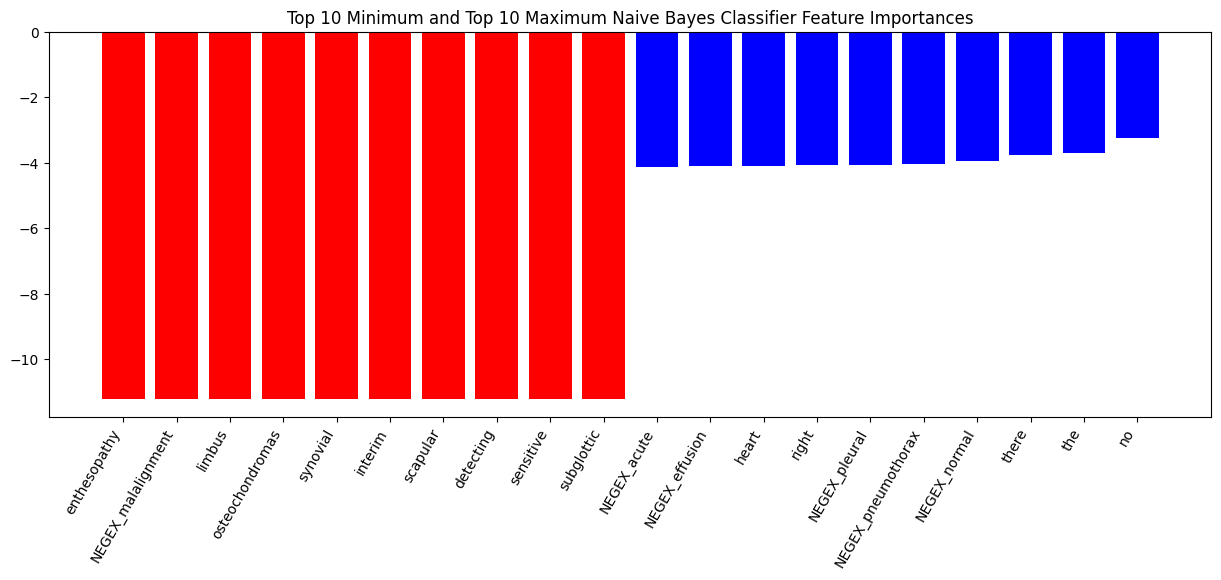

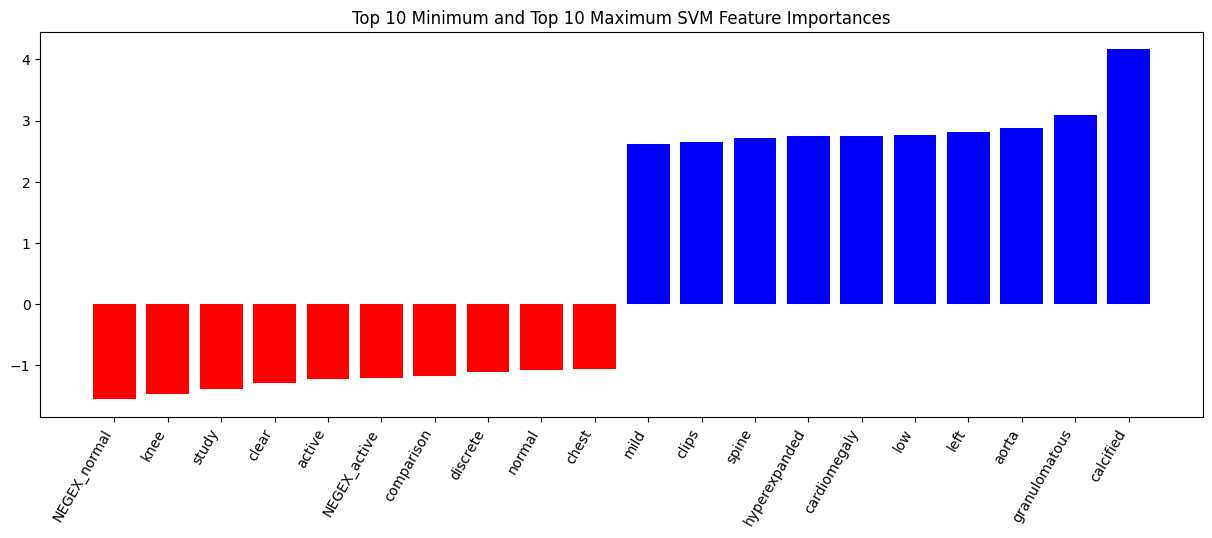

In [ ]:
import matplotlib.pyplot as plt

# Helper function that plots max and min coefficients
def plot_coefficients(classifier_feat_importances, feature_names, top_features=10):
 coef = classifier_feat_importances.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < top_features else 'blue' for c in range(len(top_coefficients))]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')

#Naive Bayes
NB_feat_importances = nb_classifier.feature_log_prob_[1,:]
plot_coefficients(NB_feat_importances, list(train_vocab_dict.values()))
plt.title('Top 10 Minimum and Top 10 Maximum Naive Bayes Classifier Feature Importances')
plt.show()

print('\n\n\n')

#SVM (TF-IDF)
SVM_feat_importances = SVM.coef_.toarray()
plot_coefficients(SVM_feat_importances, list(train_vocab_dict.values()))
plt.title('Top 10 Minimum and Top 10 Maximum SVM Feature Importances')
plt.show()


# Manual examination of model

Sometimes it is helpful (or simply entertaining) to try inserting your own free text into a NLP model and seeing how it behaves

In [ ]:
#@title Try entering some free text for classification via the classifiers we trained
user_text = "clear lungs. no pneumothorax or pleural effusion." #@param {type:"string"}
user_token = preprocess(nlp,user_text)
user_sparse_vector = sparse_vector_create(train_vocab_dict.doc2bow(user_token),len(train_vocab_dict))
user_nb_prediction = nb_classifier.predict(user_sparse_vector.reshape(1,-1))[0]
user_svm_prediction = SVM.predict(user_sparse_vector.reshape(1,-1))[0]

print("Convention used - 0 is normal, 1 is abnormal")
print(f"Naive Bayes: {user_nb_prediction}")
print(f"SVM: {user_svm_prediction}")

Convention used - 0 is normal, 1 is abnormal
Naive Bayes: 0
SVM: 0


## Error Analysis

Manual examination of model errors for systematic errors is also an important post evaluation step.

In [ ]:
troubleshoot_df = test_df.iloc[svm_metric.incorrect_index()][["full-text","label"]]
troubleshoot_df["SVM"] = [svm_predictions[i] for i in svm_metric.incorrect_index()]
troubleshoot_df

,full-text,label,SVM
3357,"The cardiomediastinal silhouette is normal in size and contour. Aortic atherosclerosis. No focal consolidation, pneumothorax or large pleural effusion. Negative for acute bone abnormality. Negative. No significant change from XXXX.",abnormal,0
1536,,normal,1
1600,Rib films. No fractures or dislocations. Chest. Heart size normal. Lungs are clear. No effusion or pneumothorax. Minimal degenerative disease thoracic spine,normal,1
1798,Normal heart size and mediastinal contours. No focal airspace consolidation. No pleural effusion or pneumothorax. Chronic appearing right mid clavicle injury. Visualized bony structures otherwise unremarkable. No acute cardiopulmonary abnormality.,normal,1
2620,Lumbar spine. No fractures. No dislocations. Disc spaces are normal. No degenerative disease. Clips in the gallbladder region. Thoracic spine. No XXXX fractures or dislocations. No significant degenerative disease. Chest. Heart size is normal. Lungs are clear. No effusion or pneumothorax.,normal,1
3516,"Chest. The trachea is midline. Negative for pneumothorax, pleural effusion or focal airspace consolidation. The heart size is normal. Abdomen. No pneumoperitoneum. There is a normal bowel XXXX pattern. Air and stool visible throughout the entire large colon including the rectum. No abnormally dilated small bowel loops. No evidence for intussusception or small bowel obstruction. No pathologic calcifications XXXX over the abdomen or pelvis. XXXX XXXX are without fracture or destructive lesion, though there are mild degenerative changes throughout the lumbar spine. Small hiatal hernia is not as well demonstrated on this exam. Chest. 1. No acute cardiopulmonary abnormality. Abdomen. 1. No acute intra-abdominal process. Negative for obstruction.",normal,1
2559,The lungs are hypoventilated. There is no focal airspace opacity. The cardiomediastinal silhouette is normal in size. There is no pneumothorax or large pleural effusion. No acute cardiopulmonary abnormality.,abnormal,0
2101,,normal,1
2295,"No focal consolidation, pneumothorax or definite pleural effusion. Heart size within normal limits, no mediastinal widening characteristic in appearance of vascular injury. No acute osseous injury XXXX demonstrated. No acute XXXX related findings. Please note that fractures may not be demonstrated and consider additional imaging if clinically indicated.",normal,1
1548,"Heart size normal. Mediastinal silhouette and vascularity are within normal limits. Lungs are clear, hyperinflated. There is no pleural effusion or pneumothorax.",abnormal,0


In [ ]:
troubleshoot_df = test_df.iloc[nb_metric.incorrect_index()][["full-text","label"]]
troubleshoot_df["nb"] = [nb_predictions[i] for i in nb_metric.incorrect_index()]
troubleshoot_df

,full-text,label,nb
2360,Heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. Degenerative changes are present in the spine. 1. No evidence of active disease.,abnormal,0
3357,"The cardiomediastinal silhouette is normal in size and contour. Aortic atherosclerosis. No focal consolidation, pneumothorax or large pleural effusion. Negative for acute bone abnormality. Negative. No significant change from XXXX.",abnormal,0
1736,"The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. Scattered bilateral calcified pulmonary nodules. No acute bone abnormality. No acute cardiopulmonary process.",abnormal,0
131,There are no focal areas of consolidation. No suspicious bony opacities. Heart size within normal limits. No pleural effusions. No evidence of pneumothorax. Mild degenerative changes of the thoracic spine. No acute cardiopulmonary abnormality.,abnormal,0
707,"Heart size upper limits of normal but stable. Tortuous aorta. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. Osseous structures are within normal limits for patient age.. 1. No acute radiographic cardiopulmonary process.",abnormal,0
...,...,...,...
3937,"Radiographic attenuation obscures detail. Grossly, the lungs are clear and expanded. Heart is large. Pulmonary XXXX are normal. Stable cardiomegaly without gross evidence for failure or pneumonia.",abnormal,0
2762,"The cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size. The lungs are mildly hypoinflated but grossly clear of focal airspace disease, pneumothorax, or pleural effusion. There are no acute bony findings. No acute cardiopulmonary findings. .",abnormal,0
1143,Stable scoliosis XXXX. The lungs are clear. Heart size normal. No pneumothorax. 1. Clear lungs. No radiographic evidence of tuberculosis. 2. Stable scoliosis XXXX. .,abnormal,0
193,"Heart size, mediastinal contour, and pulmonary vascularity are within normal limits. No focal consolidation, large pleural effusion, or pneumothorax is identified. Minimal thoracic spondylosis. No acute cardiopulmonary abnormality.",abnormal,0


# Ontology

## What is an ontology?

An ontology is a model that defines types of things that exist (classes) and their associated properties (attributes and relationships to other classes) usually within some specific domain. An ontology is a framework but does not define specific instances of each "thing". Applying this framework for specific instances gives us a knowledge graph. Of course, the Ontology framework itself can still be visualized as a graph itself.

Ontologies can be described using the Web Ontology Language (OWL) syntax.


## RadLex
Radlex is an ontology produced by RSNA [3]

An offshoot of RadLex is the RadLex Playbook [4] which aimed to standardize naming of radiology procedures based on elements of the exam such as modality and body part.



We will use the Owlready2 package which can manipulate OWL 2.0 based ontologies in Python. RadLex files are readily available for download.

In [ ]:
!pip install owlready2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 24.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for owlready2: filename=owlready2-0.47-cp310-cp310-linux_x86_64.whl size=24075202 sha256=a9c3855149b777abb3e6c4f04c99ef7ec7516cd041c527efb833a882e0220a5f
  Stored in directory: /root/.cache/pip/wheels/27/3e/ba/4171c4b10bba9fe1774fbf8fcf794de889e636ce64ad83a533
Successfully built owlready2


In [ ]:
import zipfile
import owlready2
import pandas as pd

# downloading and extracting Radlex ontology data
!curl https://radlex.org/download/RadLex_OWL4.1.zip > radlex_owl.zip
!curl https://radlex.org/Files/Radlex.xls > radlex_owl.xls


with zipfile.ZipFile("./radlex_owl.zip", 'r') as zip_ref:
    zip_ref.extractall("./")

onto = owlready2.get_ontology("./RadLex.owl").load()

df_radlex = pd.read_excel("./radlex_owl.xls")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2843k  100 2843k    0     0  5047k      0 --:--:-- --:--:-- --:--:-- 5042k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.9M  100 18.9M    0     0  34.3M      0 --:--:-- --:--:-- --:--:-- 34.3M


* Owlready2 * Warning: ignoring cyclic subclass of/subproperty of, involving:
  http://www.radlex.org/RID/Synonym



In [ ]:
import re
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer

class Radlex:
  def __init__(self,onto,df):
    self.baseurl="http://www.radlex.org/RID/#"
    self.onto = onto
    self.onto_tuple = tuple(onto.classes())
    self.df = df
    self.onto_index_list = [i.get_name(i) for i in self.onto_tuple]
    self.label_dict = dict(zip(df['Preferred Label'],df["Class ID"])) # dictionary to map preferred label to RID
    self.label_dict_keyset= set(self.label_dict.keys())
    self.id2label_dict = dict((v,k) for k,v in self.label_dict.items())
    self.synonym_dict = dict()   # dict to map synonym to preferred label
    for index, row in df[df["Synonyms"].notna()].iterrows():
      parsed_syn = row["Synonyms"].split("|")
      for syn in parsed_syn:
        #some synonm overlap with other entity names (e.g. mass is its own entity but mass is synonym of lung mass), we will exclude synonyms that match with a preferred name
        if syn not in self.label_dict_keyset:
          self.synonym_dict[syn] = row["Preferred Label"]

  def random_class(self):
    randomclass = random.choice(self.onto_tuple)
    return randomclass

  def lookup(self,id):
    #row lookup by id
    #input is the radlex class id in format RID#### which is the output from the radlex class.name element
    df_full = self.df.loc[self.df["Class ID"] == self.baseurl+str(id)]

    return df_full

  def lookup_short(self,id):
    #only return columns with non-null values
    df = self.lookup(id)
    return df[df.columns[~df.isnull().any()]]

  def onto_class(self,id):
    #return the owl entity of the given the radlex class id which should be provided in format of string "RID####"
    #need owl entity object to use owlready2 class methods like get_children_of
    indice = self.onto_index_list.index(id)
    target_class = self.onto_tuple[indice]
    return target_class

  def get_parents(self,id):
    #return owl object parent(s) of given input ID in string RID####
    id_class = self.onto_class(id)
    parent_classes = self.onto.get_parents_of(id_class)

    return parent_classes

  def get_siblings(self,id):
    # returns list rid string of siblings, aka children of parent of id
    parent = self.get_parents(id)[0] #just take first parent for now
    children = self.onto.get_children_of(parent)
    children_list = [c.name for c in children]

    return children_list

  def are_siblings(self,id1,id2):
    #given 2 RID, return True if they are siblings, otherwise False
    #by definition, siblings should share same parent
    parent1 = self.get_parents(id1)[0]
    parent2 = self.get_parents(id2)[0]

    if parent1.name == parent2.name:
      return True
    else:
      return False

  def get_nth_parent(self,id,n=1):
    # at minimum will return direct parent
    # unlike get_parents, will return id as string instead of owl class
    i=0
    if n < 0:
      print("nth parent cannot be negative")
      return
    n = round(n)
    if id == "RID0":
      print("Already at Radlex origin")
      return id

    parent = self.get_parents(id)[0]
    while i < n-1:
      try:
        parent = self.get_parents(parent.name)[0]
      except:
        print("Error, n may exceed bounds. Will return last generation")
        return parent.name
      i +=1
    return parent.name

  def rid2df(self,rid_list):
    #convert list of rid strings into df
    df = pd.DataFrame()
    for rid in rid_list:
      df = pd.concat([df,self.lookup(rid)])
    return df


  def label2id(self,label):
    # map text of RID to RID####

    # first map synonym to preferred label,
    if label in self.synonym_dict:
      label = self.synonym_dict[label]

    # map label to id (RID####)
    if label in self.label_dict:
      id = self.label_dict[label]
      # the dictionary id value is in format of http://www.radlex.org/RID/#RIDXXXX, just want the RID portion
      pattern = self.baseurl+"(.+)"
      regmatch = re.search(pattern,id)
      return regmatch.group(1)
    else:
      return

  def report_rid(self,text,n=7):
    #input text as string, returns list of RID associated with text
    #n is the maximum ngram to consider, default set to 7
    lemmatizer = WordNetLemmatizer()
    rid_list = list()

    for n in range(1,n+1):
      for n_gram in [" ".join(w) for w in ngrams(preprocess(nlp,text),n)]:
        rid = self.label2id(n_gram)
        rid_lemma = self.label2id(lemmatizer.lemmatize(n_gram))
        if rid and rid not in rid_list:
          rid_list.append(rid)

        if rid_lemma and rid_lemma not in rid_list:
          rid_list.append(rid_lemma)

    return rid_list


rad = Radlex(onto,df_radlex)

We have created a class with some useful methods for navigating the ontology. One particular useful application is to convert a text report into relevant RadLex entities. Takes around 10 minutes to run for all reports, we will just examine the first 1001 (runtime approx 2 minutes)

In [ ]:
from tqdm import tqdm

#dictionary of report id mapped to matched RID
report_rid_dict = dict()

for index,row in tqdm(reports_df[0:1000].iterrows()):
  #run report_rid method on full text report corresponding to a given id, save as key-value
  report_rid_dict[row["id"]] = set(rad.report_rid(row["full-text"]))


1000it [02:45,  6.04it/s]


In [ ]:
pd.set_option('display.max_colwidth',None)
df_report_rid = pd.DataFrame(report_rid_dict.items())
df_report_rid.columns = ["ID", "RID"]
df_report_rid

,ID,RID
0,2780,"{RID1385, RID38670, RID1384, RID13173, RID28475, RID13437, RID5782, RID5770, RID1301}"
1,2080,"{RID5774, RID38670, RID33, RID5747, RID3953, RID5957, RID28475, RID13437, RID1302, RID5825, RID1301}"
2,2474,"{RID6251, RID5869, RID5774, RID480, RID1385, RID5967, RID46058, RID5771, RID28538, RID5704, RID5916, RID1547, RID5770}"
3,1626,"{RID39120, RID1385, RID5967, RID46058, RID5771, RID13173, RID4247, RID1338, RID39446, RID5824, RID28475, RID3875, RID1301}"
4,2136,"{RID38670, RID5778, RID5957, RID13437, RID28475, RID1301}"
...,...,...
995,3266,"{RID5718, RID38670, RID28475, RID13437, RID1301}"
996,1200,"{RID5774, RID39317, RID1385, RID13173, RID28530, RID5827, RID15989, RID1243, RID28475, RID13437, RID5864, RID6336, RID8, RID35808, RID5825, RID1301}"
997,3804,"{RID43591, RID39121, RID480, RID879, RID5747, RID4128, RID5172, RID5086, RID39268, RID3953, RID5829, RID5824, RID28475, RID39049, RID7741, RID5734, RID34572}"
998,1894,"{RID1385, RID38670, RID13173, RID28530, RID49687, RID13298, RID28475, RID13437, RID36043, RID29978, RID5825, RID1301}"


What can we do with this information? One way to utilize Ontology labeled text is to enhance search. We can search our database of text for terms and its related terms with a single query based on relationships defined in the Ontology.

In [ ]:
matched_id = list()

search_term = "cardiomyopathy" #@param{type:"string"}
search_term_rid = rad.label2id(search_term)

if search_term_rid is not None:
  search_term_children = rad.onto.get_children_of(rad.onto_class(search_term_rid))
  search_term_siblings = rad.get_siblings(search_term_rid)
  print("Terms searched:")
  for sib in search_term_siblings:
    print(rad.id2label_dict[(lambda x: rad.baseurl+x)(sib)])
    for key,value in list(report_rid_dict.items()):
      if sib in value:
        matched_id.append(key)

  for child in search_term_children:
    try:
      print(rad.id2label_dict[(lambda x: rad.baseurl+x)(child.name)])
    except:
      #in rare instance that a RID key doesn't exist, for some reason thyroid nodule doesn't get imported
      print(f"missing entity {child.name}")

    for key,value in list(report_rid_dict.items()):
      if child.name in value:
        matched_id.append(key)
else:
  print("Please enter name of RID entity")
print("*"*75)
for id in matched_id:
  print(id, reports_df.loc[reports_df['id'] == id ]["full-text"].values)

Terms searched:
ischemic heart disease
cardiomyopathy
valvular heart disease
septal defect
pericardial disease
cor pulmonale
cardiac tamponade
tetralogy of Fallot
partial anomalous pulmonary venous return
total anomalous pulmonary venous return
heart failure
dilated cardiomyopathy
ischemic cardiomyopathy
hypertrophic cardiomyopathy
restrictive cardiomyopathy
***************************************************************************
216 ['The cardiac silhouette is enlarged and has a globular appearance. Mild bibasilar dependent atelectasis. No pneumothorax or large pleural effusion. No acute bone abnormality. Cardiomegaly with globular appearance of the cardiac silhouette. Considerations would include pericardial effusion or dilated cardiomyopathy.']
88 ['Heart is mildly heart enlarged. Mediastinal contour normal. There is mild diffuse interstitial prominence suggestive of edema. No focal airspace consolidation or pleural effusion. Degenerative changes of the the spine. 1. Findings con

# Where to next?
So far we have only examined sparse word vectors. That is, vector representations of words that contain many 0's and sparsely contain data (in this case, a bag of words representation based on word count and frequency). This approach may perform adequately for the models used and question being answered, but for many cases, working with these large-dimension vectors can be a large problem due to high memory usage and computational cost.

There has been work done to create dense vector representations of words based on "distributed" representations (aka based on word distribution). These vectors are are usually only several tens to hundreds of dimensions long as opposed to many thousands. Earlier approaches for doing so include Word2vec and GloVe which create static vectors for word representations. Newer embedding approaches such as with transformers integrate context into embedding creation.

Popular deep learning architectures for analyzing text include convolutional neural networks, recurrent neural networks and its cousins LSTM and GRU as well as the transformer model. Deep learning approaches to NLP start with converting words into a vector in an embedding layer, often using one of the aforementioned techniques.

We will not explore deep learning approaches to NLP in this tutorial, but since we have mentioned a number of popular NLP packages, we will also mention [HuggingFace](https://huggingface.co/) for their extensive NLP deep learning library.

At the extreme end are the so-called Large Language Models which are enormous models built based on the transformer architecture. At this extreme scale, there are many non-intuitive properties that arise including apparent ability to reason as well as be readily applied to a broad variety of tasks without the need for fine tuning.

How these models work and perform so well on tasks that were previously extremely challenging for older models is still not understood. Although these models represent a large leap in terms of NLP progress, there is much work that remains to be done including research into when they fail and how they can safely be applied to clinical care.


# References

[1] Demner-Fuhshman D, Kohli MD, Rosenman MB, Shooshan SE, Rodriguez L, Antani S, Thoma GR, McDonald CJ. "Preparing a collection of radiology examinations for distribution and retrieval". J. Am. Med. Inform. Assoc. 2016. 23(2). 304-310. https://doi.org/10.1093/jamia/ocv080

[2] Wiggins WF, Kitamura F, Santos I, Prevedello L. "Natural Language Processing of Radiology Text Reports: Interactive Text Classification". Radiol. Artif. Intell. 2021. 3(4). https://doi.org/10.1148/ryai.2021210035

[3] Chepelev LL, et. al. "Ontologies in the New Computational Age of Radiology: RadLex for Semantics and Interoperability in Imaging Workflows". RadioGraphics. 2023. 43(3). e220098. https://doi.org/10.1148/rg.220098

[4] Wang, et. al., "Use of Radiology Procedure Codes in Health Care: The Need for Standardization and Structure". RadioGraphics. 2017. 37(4). 1099-1110. https://pubs.rsna.org/doi/pdf/10.1148/rg.2017160188

#Further Reading
Jurafsky D, Martin JH. "Speech and Language Processing. An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition". Draft. 3ed. September 21, 2021.

Pons E, Braun LM M, Hunink MG Myriam, Kors JA. "Natural Language Processing in Radiology: A Systematic Review". Radiology. 2016. 279(2). 329-343.

Sorin V, Barash Y, Konen E, Klang E. "Deep Learning for Natural Language Processing in Radiology - Fundamentals and a Systematic Review". J. Am. Coll. Radiol. 2020. 17(5). 639-648.

Mozayan A, Fabbri AR, Maneevese M, Tocino I, Chheang Sophie. "Practical Guide to Natural Language Processing for Radiology". Radiographics. 2021. 41(5). 1446-1453.

#Answers to Regex Practice Problem


In [ ]:
#@title Question 1: Find and remove all punctuation within the text block

regex_pattern = '[^\w ]' #Match all characters that are NOT ("^") words ("\w") or spaces (" ")

text_block = """
There is no significant end-vessel ischemic small vessel disease.
There is no acute infarct seen.
No intracranial hemorrhage is recognized.
"""
out_text = re.sub(regex_pattern, ' ', text_block)

print(out_text)

 There is no significant end vessel ischemic small vessel disease  There is no acute infarct seen  No intracranial hemorrhage is recognized  


In [ ]:
#@title Question 2: Extract full impression from the text block

regex_pattern = "IMPRESSION\n((.|\n)*)" #Match to "IMPRESSION\n" and then use a match capturing group ("(...)") that matches
                                        #at least one ("*") of any character (".") or new line ("\n") from the
                                        #"IMPRESSION\n" until the end of the string.

text_block = """
FINDINGS:
FLUID / INTRA-ARTICULAR BODIES: There is a small knee effusion and a small popliteal cyst present. There is circumferential soft tissue edema and swelling at the level the knee most prominent posteriorly.
MENISCI:
Medial: The medial meniscus is normal.
Lateral: The lateral meniscus is normal.

IMPRESSION
1. There are extensive bone contusions of the distal femur and proximal tibia. There is a nondisplaced Salter II fracture through the growth plate of the distal femur. There is a subperiosteal hematoma with displacement of the periosteum along the posterolateral aspect of the distal femoral metaphysis.
2. Extensive bone contusion of the proximal tibia with a small incomplete nondisplaced transverse fracture line noted along the posterior margin of the proximal tibial metaphysis.
"""

m = re.search(regex_pattern,text_block)
for group in m.groups():
  print(group)
  print()


1. There are extensive bone contusions of the distal femur and proximal tibia. There is a nondisplaced Salter II fracture through the growth plate of the distal femur. There is a subperiosteal hematoma with displacement of the periosteum along the posterolateral aspect of the distal femoral metaphysis.
2. Extensive bone contusion of the proximal tibia with a small incomplete nondisplaced transverse fracture line noted along the posterior margin of the proximal tibial metaphysis.





